# SWC Case

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.10f}'.format

from sklearn import tree
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import StackingClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, roc_curve

from sklearn.manifold import TSNE
import optuna #Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning.
from optuna.samplers import TPESampler
import pickle
from sklearn.feature_selection import VarianceThreshold


In [2]:
train_data = pd.read_csv('train_data_swc.csv')
test_data = pd.read_csv('test_data_swc.csv') # this is not validation data
example_data = pd.read_csv('example.csv')

In [ ]:
print('number of data points in the train data: ' , len(train_data))
print('number of data points in the test data: ' , len(test_data))

In [ ]:
train_data.head(5)

In [ ]:
test_data.head(5)

In [ ]:
class_counts = train_data['y'].value_counts()
class_percentages = class_counts / len(train_data) * 100
plt.bar(class_percentages.index, class_percentages)
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Class Distribution in the Dataset')
plt.show()

## Preprocessing

### Correlation among Features

In [ ]:
corr_matrix = train_data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

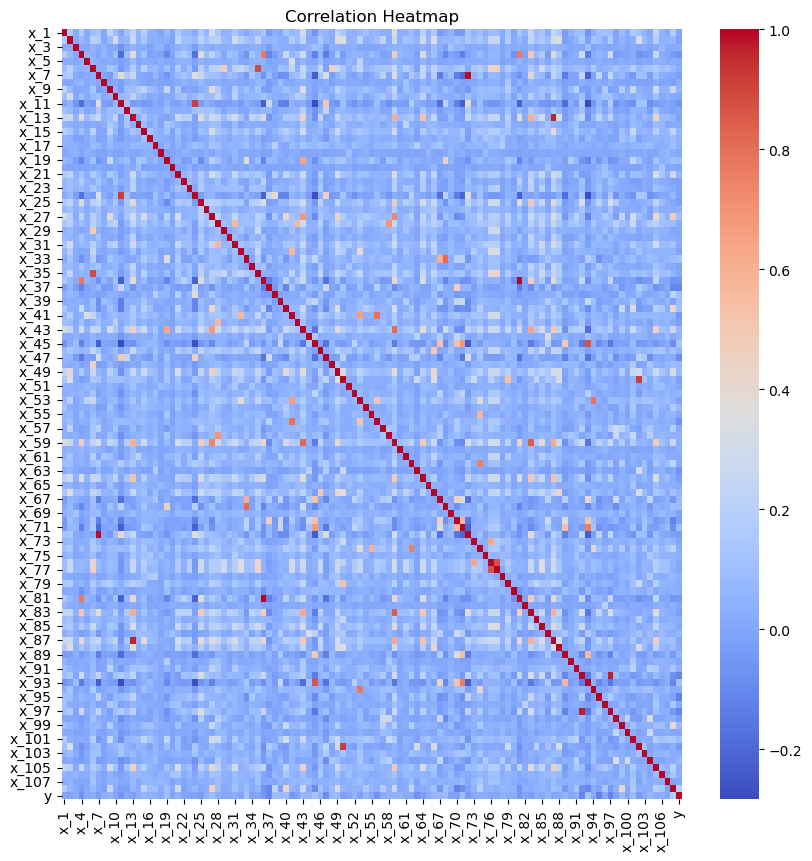

In [3]:
train_classes_two_and_three = train_data[(train_data['y'] == 2) | (train_data['y'] == 3)]
corr_matrix = train_classes_two_and_three = train_data[(train_data['y'] == 2) | (train_data['y'] == 3)].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:

corr_matrix = train_data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
train_data[train_data.columns[1:]].corr()['y'][:].sort_values(ascending=False)

## Feature Engineering

### Variance Threshold

In [3]:
X = train_data.iloc[:,0:107]
vt = VarianceThreshold(threshold=0.05)
vt.fit(X)

# find the features that meet the variance threshold
mask = vt.get_support()
chosen_features = list(X.loc[:, mask].columns)
removed_features = [feature for feature in X.columns if feature not in chosen_features]

# show the chosen and removed features
print('Chosen features: ', chosen_features)
print('Removed features: ', removed_features)

Chosen features:  ['x_2', 'x_4', 'x_6', 'x_7', 'x_8', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_19', 'x_20', 'x_21', 'x_23', 'x_24', 'x_25', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_49', 'x_50', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_62', 'x_64', 'x_66', 'x_67', 'x_68', 'x_69', 'x_70', 'x_71', 'x_72', 'x_73', 'x_74', 'x_75', 'x_76', 'x_77', 'x_78', 'x_80', 'x_81', 'x_83', 'x_84', 'x_85', 'x_86', 'x_87', 'x_88', 'x_89', 'x_90', 'x_92', 'x_93', 'x_94', 'x_97', 'x_98', 'x_100', 'x_101', 'x_102', 'x_103', 'x_104', 'x_105']
Removed features:  ['x_1', 'x_3', 'x_5', 'x_9', 'x_18', 'x_22', 'x_26', 'x_34', 'x_42', 'x_48', 'x_51', 'x_61', 'x_63', 'x_65', 'x_79', 'x_82', 'x_91', 'x_95', 'x_96', 'x_99', 'x_106', 'x_107']


In [4]:
if(True):    
    test_data = test_data[chosen_features]
    print(len(chosen_features))
    chosen_features.append('y')
    print(len(chosen_features))
    train_data = train_data[chosen_features]
     

85
86


### TSNE

In [4]:
X_tsne = TSNE(learning_rate=100).fit_transform(train_data.drop(['y'], axis = 1))

In [19]:
classes = list(train_data['y'].unique())

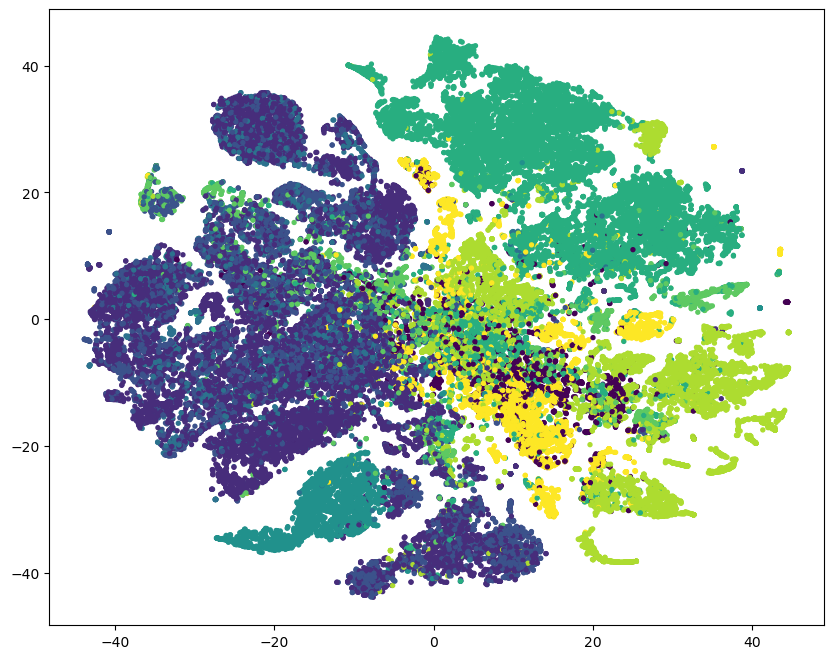

In [21]:

plt.figure(figsize=(10, 8))

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_data['y'], s=8)

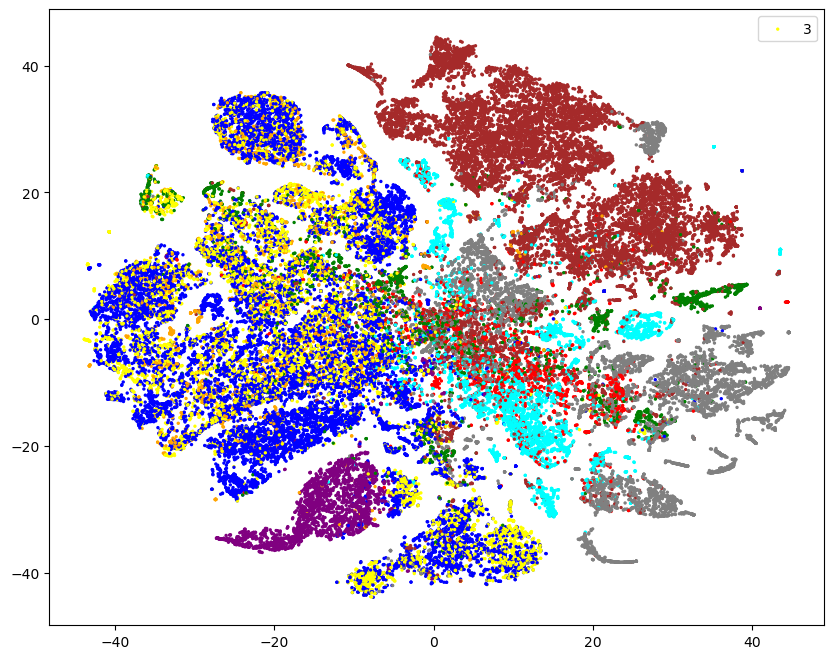

In [32]:

plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'yellow', 'orange', 'purple', 'brown', 'green', 'gray', 'cyan']
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_data['y'], s=2, cmap=ListedColormap(colors))
plt.legend(classes)
plt.show()

In [ ]:
class_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan']
class_markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', '*']

# Create a scatter plot
plt.figure(figsize=(10, 8))

for i in range(9):
    class_df = df[df['classes'] == i]
    plt.scatter(class_df['x'], class_df['y'], label=f'Class {i}', color=class_colors[i], marker=class_markers[i], s=10)

# Adjust plot settings
plt.title('2D Scatter Plot with 9 Classes')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

## ML Models

In [6]:
X = train_data.drop(['y'], axis = 1)
y = train_data['y']
number_f_class = len(y.unique())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)
print("number of classes: ", number_f_class)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

number of classes:  9
(50000, 85) (12500, 85) (50000,) (12500,)


### K-nearest Classifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 1).fit(X_train, y_train) 

predicted = knn.predict(X_test)
predicted_train = knn.predict(X_train)

accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)

print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')

### Naive Bayes Classifier

In [ ]:
gnb = GaussianNB().fit(X_train, y_train) 
predicted = gnb.predict(X_test)
predicted_train = gnb.predict(X_train)

accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)

print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')

### SVM - Linear Kernel

In [ ]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 

svm_predictions_train = svm_model_linear.predict(X_train)

# model accuracy for X_train
accuracy_svmlinear_train = svm_model_linear.score(X_train, y_train) 

# model accuracy for X_test   
accuracy_svmlinear_test = svm_model_linear.score(X_test, y_test) 

print(f'Accuracy_train: {accuracy_svmlinear_train}')
print(f'Accuracy_test: {accuracy_svmlinear_test}')

### Decision Tree Model

In [ ]:
dt = DecisionTreeClassifier(random_state = 10, max_depth = 22)
dt.fit(X_train, y_train)
predicted = dt.predict(X_test)
predicted_train = dt.predict(X_train)
accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)
print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')

In [ ]:
#classes = [str(x) for x in train_data['y'].unique().tolist()]
#fig = plt.figure(figsize = (20, ))
#_ = tree.plot_tree(model, feature_names = X.columns.values.tolist(),class_names = classes, filled = True)
#fig.savefig("decision_tree.png")

### Balanced Bagging Classifier

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#Create an instance
classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=11)
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
predicted_train = classifier.predict(X_train)
accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)
print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')
print(confusion_matrix(y_test, predicted))
print(confusion_matrix(y_train, predicted_train))



### LightGBM Model

In [ ]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": number_f_class,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    accuracy_test = accuracy_score(y_test, preds)
    return accuracy_test

In [ ]:

# this part has already been run and we took the required results which are the best parameters
#sampler = TPESampler(seed=1)
#study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)
#print('Best parameters:', study.best_params)
#print('Best value:', study.best_value)
#print('Best trial:', study.best_trial)

In [7]:
# these are the best parameters that have been found by optuna
best_parameters = {'lambda_l1': 5.117571145089835e-06, 'lambda_l2': 0.08753895882464374, 'num_leaves': 199, 'feature_fraction': 0.606773610653303, 'bagging_fraction': 0.8462643326394661, 'bagging_freq': 2, 'min_child_samples': 89}
lgbm = lgb.LGBMClassifier(**best_parameters)
lgbm.fit(X_train, y_train)
predicted = lgbm.predict(X_test)
predicted_train = lgbm.predict(X_train)
accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)
print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')
print(confusion_matrix(y_test, predicted))
print(confusion_matrix(y_train, predicted_train))

y_proba = lgbm.predict_proba(X_test)

# Evaluate the log loss of the stacking classifier (for probabilistic predictions)
log_loss_value = log_loss(y_test, y_proba)
print(f"LGBMC Log Loss: {log_loss_value}")

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=5.117571145089835e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.117571145089835e-06
[LightGBM] [Warning] feature_fraction is set=0.606773610653303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.606773610653303
[LightGBM] [Warning] bagging_fraction is set=0.8462643326394661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462643326394661
[LightGBM] [Warning] lambda_l2 is set=0.08753895882464374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08753895882464374
Accuracy_train: 0.98382
Accuracy_test: 0.82216
[[ 202    9    3    0    1   30   11   53   71]
 [   1 2794  440   33    5   13   20    7    7]
 [   1  645  883   26    2    4   33    3    1]
 [   0  149   71  300    3   19    8    2    1]
 [   1    7    1    0  542    0    1    0    0]
 [   9   15    6    0    0 2810

#### THIS PART IS FOR CREATING THE FINAL DELIVERY

In [ ]:
y_probability_final = lgbm.predict_proba(test_data)

In [ ]:
y_probability_final = pd.DataFrame(y_probability_final ,columns=['c1','c2','c3','c4','c5','c6','c7','c8','c9'])
y_probability_final.head(5)

In [ ]:
y_probability_final.to_csv('y_probability_final.csv', index=False, float_format='%.10f')

In [ ]:
print(lgbm.feature_importances_)

In [ ]:
print(y_proba[1])



## Stacking Ensemble Model

In [ ]:
lr_meta = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42)

# Create the stacking classifier
stacking_clf = StackingClassifier(
    estimators=[('gnb', gnb), ('dt', dt), ('lgbm', lgbm)],
    final_estimator=lr_meta,
    cv=5  # Number of cross-validation folds
)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = stacking_clf.predict(X_test)

# Evaluate the accuracy of the stacking classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Stacking Classifier Accuracy: {accuracy}")


# Make predictions (probabilities) on the test set
y_proba = stacking_clf.predict_proba(X_test)

# Evaluate the log loss of the stacking classifier (for probabilistic predictions)
log_loss_value = log_loss(y_test, y_proba)
print(f"Stacking Classifier Log Loss: {log_loss_value}")

In [ ]:
# Make predictions (probabilities) on the test set
y_proba = stacking_clf.predict_proba(X_test)

# Evaluate the log loss of the stacking classifier (for probabilistic predictions)
log_loss_value = log_loss(y_test, y_proba)
print(f"Stacking Classifier Log Loss: {log_loss_value}")

In [ ]:
# Make predictions (probabilities) on the test set
y_proba = stacking_clf.predict_proba(X_train)

# Evaluate the log loss of the stacking classifier (for probabilistic predictions)
log_loss_value_train = log_loss(y_train, y_proba)
print(f"Stacking Classifier Log Loss: {log_loss_value_train}")